In [1]:
import os, sys
sys.path.append('/home/ltetrel/DeepNeuroAN/deepneuroan/')
sys.path.append('/home/ltetrel/DeepNeuroAN/')

import numpy as np
np.set_printoptions(precision=2)
import tensorflow as tf

from preproc import create_ref_grid
import deepneuroan.utils as utils
import SimpleITK as sitk

tf.keras.backend.clear_session()

!python3 -m pip install --user tensorflow_graphics tensorflow-probability

Keyring is skipped due to an exception: org.freedesktop.DBus.Error.FileNotFound: Failed to connect to socket /run/user/1409/bus: No such file or directory


In [ ]:
# inputs creation   
batch_size = 10
x = np.empty((batch_size, 9, 9, 9, 1), dtype=np.float64)
trf = np.empty((batch_size, 7), dtype=np.float64)
data_dir = "./data"

for i in range(batch_size):
    x[i, :, :, :, 0] = sitk.GetArrayFromImage(sitk.ReadImage(data_dir + "/ses-vid001_task-video_run-01_bold_vol-0001_transfo-%06d.nii.gz" %(i+1)
                                   , sitk.sitkFloat64))[100:109, 110:119, 120:129]

    trf[i,] = utils.load_trf_file(data_dir + "/ses-vid001_task-video_run-01_bold_vol-0001_transfo-%06d.txt" %(i+1))
    
    # Inversing quaternions to compare volumes with base one
    q = sitk.VersorRigid3DTransform([trf[i, 1], trf[i, 2], trf[i, 3], trf[i, 0]])
    t = sitk.TranslationTransform(3, tuple(trf[i, 4:]))
    q.SetTranslation(t.GetOffset())
    q = q.GetInverse().GetParameters()
    trf[i, 1:4] = [-trf[i, 1], -trf[i, 2], -trf[i, 3]]
    trf[i, 4:] = q[3:]

In [ ]:
class LinearTransformation(tf.keras.layers.Layer):
    def __init__(self, **kwargs):
        self.trainable = False
        super(self.__class__, self).__init__(**kwargs)

    def build(self, input_shape):
        assert isinstance(input_shape, list)
        if len(input_shape) > 2:
            raise Exception("LinearRegistration must be called on a list of length 2. "
                            "First argument is the volume, second is the quaternion transform.")

        super(self.__class__, self).build(input_shape)

    def call(self, inputs):
        assert isinstance(inputs, list)
        
        #https://www.tensorflow.org/graphics/api_docs/python/tfg/math/interpolation/bspline/interpolate
        #https://www.tensorflow.org/probability/api_docs/python/tfp/math/batch_interp_regular_nd_grid
        #https://tensorlayer.readthedocs.io/en/latest/_modules/tensorlayer/layers/spatial_transformer.html
        
        # map transform across batch
        return tf.map_fn(self._tf_single_transform, inputs, dtype=tf.float32)
            
    def compute_output_shape(self, input_shape):
        return input_shape[0]   
    
    def _single_transform(self, src, trf):
        ref_grid = create_ref_grid()

        sitk_src = utils.get_sitk_from_numpy(src, ref_grid)
        sitk_tgt = utils.transform_volume(sitk_src, ref_grid, rigid=trf)

        return sitk.GetArrayFromImage(sitk_tgt)
    
    @tf.function
    def _tf_single_transform(self, inputs): 
        out = tf.numpy_function(self._single_transform, inp=[inputs[0], inputs[1]], Tout=tf.float32) 
        return out


In [ ]:
#TODO: When it is working, uncomment

# n_batch = 7
# transfos = tf.random.uniform(shape=(n_batch, 7), seed=0) #quaternions (4,) + translations (3,) + scales (3,)
# U = tf.random.uniform((n_batch, 220, 220, 220, 1))
# out_size = [10, 10, 10]
# name='BatchSpatialTransformer3dAffine'

# ref_grid = create_ref_grid()
# sz_ref = ref_grid.GetSize()
# min_ref_grid = ref_grid.GetOrigin()
# max_ref_grid = ref_grid.TransformIndexToPhysicalPoint(sz_ref)

# with tf.compat.v1.variable_scope(name):


In [ ]:
# inspired from https://tensorlayer.readthedocs.io/en/latest/_modules/tensorlayer/layers/spatial_transformer.html
def _repeat(x, n_repeats):
    rep = tf.transpose(a=tf.expand_dims(tf.ones(
                                                shape=tf.stack([n_repeats,])
                                                ), 1)
                       , perm=[1, 0])
    rep = tf.cast(rep, dtype=tf.int32)
    x = tf.matmul(tf.reshape(x, (-1, 1)), rep)
    return tf.reshape(x, [-1])

def _interpolate(im, p, out_size, min_ref_grid, max_ref_grid):

    # getting position coords as arrays
    x = tf.reshape(tf.slice(p, [0, 0, 0], [-1, 1, -1]), [-1])
    y = tf.reshape(tf.slice(p, [0, 1, 0], [-1, 1, -1]), [-1])
    z = tf.reshape(tf.slice(p, [0, 2, 0], [-1, 1, -1]), [-1])

    # constants
    num_batch = tf.shape(im)[0]
    height = tf.shape(im)[1]
    width = tf.shape(im)[2]
    depth = tf.shape(im)[3]
    channels = tf.shape(im)[4]
    out_height = out_size[0]
    out_width = out_size[1]
    out_depth = out_size[2]
    height_f = tf.cast(height, dtype=tf.float32)
    width_f = tf.cast(width, dtype=tf.float32)
    depth_f = tf.cast(depth, dtype=tf.float32)
    zero = tf.zeros([], dtype=tf.float32)

    # scale positions to [0, width/height - 1]
    ix = (x - min_ref_grid[0]) * (width_f - 1.)/(max_ref_grid[0] - min_ref_grid[0])
    iy = (y - min_ref_grid[1]) * (height_f - 1.)/(max_ref_grid[1] - min_ref_grid[1])
    iz = (z - min_ref_grid[2]) * (depth_f - 1.)/(max_ref_grid[2] - min_ref_grid[2])

    # border padding mode, for positions outside of refrence grid
    ix = tf.clip_by_value(ix, zero, width_f - 1)
    iy = tf.clip_by_value(iy, zero, height_f - 1)
    iz = tf.clip_by_value(iz, zero, depth_f - 1)

    # get corner indexes based on the scaled positions
    # nwt stands for north-west-top; seb stands for south-east-bottom
    ix_nwt = tf.floor(ix)
    iy_nwt = tf.floor(iy)
    iz_nwt = tf.floor(iz)
    ix_net = ix_nwt + 1
    iy_net = iy_nwt
    iz_net = iz_nwt
    ix_swt = ix_nwt
    iy_swt = iy_nwt + 1
    iz_swt = iz_nwt
    ix_set = ix_nwt + 1
    iy_set = iy_nwt + 1
    iz_set = iz_nwt
    ix_nwb = ix_nwt
    iy_nwb = iy_nwt
    iz_nwb = iz_nwt + 1
    ix_neb = ix_nwt + 1
    iy_neb = iy_nwt
    iz_neb = iz_nwt + 1
    ix_swb = ix_nwt
    iy_swb = iy_nwt + 1
    iz_swb = iz_nwt + 1
    ix_seb = ix_nwt + 1
    iy_seb = iy_nwt + 1
    iz_seb = iz_nwt + 1

    # calculate the weights for each p position
    nwt = tf.expand_dims(((ix_seb - ix)    * (iy_seb - iy)    * (iz_seb - iz)), 1)
    net = tf.expand_dims(((ix    - ix_swb) * (iy_swb - iy)    * (iz_swb - iz)), 1)
    swt = tf.expand_dims(((ix_neb - ix)    * (iy    - iy_neb) * (iz_neb - iz)), 1)
    set = tf.expand_dims(((ix    - ix_nwb) * (iy    - iy_nwb) * (iz_nwb - iz)), 1)
    nwb = tf.expand_dims(((ix_set - ix)    * (iy_set - iy)    * (iz - iz_set)), 1)
    neb = tf.expand_dims(((ix    - ix_swt) * (iy_swt - iy)    * (iz - iz_swt)), 1)
    swb = tf.expand_dims(((ix_net - ix)    * (iy    - iy_net) * (iz - iz_net)), 1)
    seb = tf.expand_dims(((ix    - ix_nwt) * (iy    - iy_nwt) * (iz - iz_nwt)), 1)

    # gather input img values from positions
    # get corners idx
    ibatch = _repeat(tf.range(num_batch) * height * width * depth, out_height * out_width * out_depth)
    idx_nwt = ibatch + tf.cast(tf.clip_by_value(ix_nwt, zero, width_f - 1), tf.int32) + tf.cast(tf.clip_by_value(iy_nwt, zero, height_f - 1), tf.int32) * width + tf.cast(tf.clip_by_value(iz_nwt, zero, depth_f - 1), tf.int32) * width * height
    idx_net = ibatch + tf.cast(tf.clip_by_value(ix_net, zero, width_f - 1), tf.int32) + tf.cast(tf.clip_by_value(iy_net, zero, height_f - 1), tf.int32) * width + tf.cast(tf.clip_by_value(iz_net, zero, depth_f - 1), tf.int32) * width * height
    idx_swt = ibatch + tf.cast(tf.clip_by_value(ix_swt, zero, width_f - 1), tf.int32) + tf.cast(tf.clip_by_value(iy_swt, zero, height_f - 1), tf.int32) * width + tf.cast(tf.clip_by_value(iz_swt, zero, depth_f - 1), tf.int32) * width * height
    idx_set = ibatch + tf.cast(tf.clip_by_value(ix_set, zero, width_f - 1), tf.int32) + tf.cast(tf.clip_by_value(iy_set, zero, height_f - 1), tf.int32) * width + tf.cast(tf.clip_by_value(iz_set, zero, depth_f - 1), tf.int32) * width * height
    idx_nwb = ibatch + tf.cast(tf.clip_by_value(ix_nwb, zero, width_f - 1), tf.int32) + tf.cast(tf.clip_by_value(iy_nwb, zero, height_f - 1), tf.int32) * width + tf.cast(tf.clip_by_value(iz_nwb, zero, depth_f - 1), tf.int32) * width * height
    idx_neb = ibatch + tf.cast(tf.clip_by_value(ix_neb, zero, width_f - 1), tf.int32) + tf.cast(tf.clip_by_value(iy_neb, zero, height_f - 1), tf.int32) * width + tf.cast(tf.clip_by_value(iz_neb, zero, depth_f - 1), tf.int32) * width * height
    idx_swb = ibatch + tf.cast(tf.clip_by_value(ix_swb, zero, width_f - 1), tf.int32) + tf.cast(tf.clip_by_value(iy_swb, zero, height_f - 1), tf.int32) * width + tf.cast(tf.clip_by_value(iz_swb, zero, depth_f - 1), tf.int32) * width * height
    idx_seb = ibatch + tf.cast(tf.clip_by_value(ix_seb, zero, width_f - 1), tf.int32) + tf.cast(tf.clip_by_value(iy_seb, zero, height_f - 1), tf.int32) * width + tf.cast(tf.clip_by_value(iz_seb, zero, depth_f - 1), tf.int32) * width * height
 
    # gather input image values from idx
    im_flat = tf.reshape(im, tf.stack([-1, channels]))
    I_nwt = tf.gather(im_flat, idx_nwt)
    I_net = tf.gather(im_flat, idx_net)
    I_swt = tf.gather(im_flat, idx_swt)
    I_set = tf.gather(im_flat, idx_set)
    I_nwb = tf.gather(im_flat, idx_nwb)
    I_neb = tf.gather(im_flat, idx_neb)
    I_swb = tf.gather(im_flat, idx_swb)
    I_seb = tf.gather(im_flat, idx_seb)
    
    output = tf.add_n([nwt * I_nwt, net * I_net, swt * I_swt, set * I_set, nwb * I_nwb, neb * I_neb, swb * I_swb, seb * I_seb])
    return output

In [ ]:
import time

x = tf.constant([[5., 5., 5.], [5., 5., 5.]])
y = tf.constant([[5., 7., 10.], [5., 5., 6.]])

tic = time.time()
for i in range(1000):
    y + (x-y)*tf.cast(tf.math.less(x, y), dtype=tf.float32)
ElpsTime = time.time() - tic
print("*** Total %1.3f s ***"%(ElpsTime))

tic = time.time()
for i in range(1000):
    tf.math.minimum(5., y)
ElpsTime = time.time() - tic
print("*** Total %1.3f s ***"%(ElpsTime))

tic = time.time()
for i in range(1000):
    tf.clip_by_value(y, 0., 5.)
ElpsTime = time.time() - tic
print("*** Total %1.3f s ***"%(ElpsTime))

tic = time.time()
for i in range(1000):
    tf.clip_by_value(y, 0., 5.)
ElpsTime = time.time() - tic
print("*** Total %1.3f s ***"%(ElpsTime))

In [ ]:
ix = tf.random.uniform(shape=(220*220*220,), minval=-50, maxval=50, seed=0, dtype=tf.float32)
iy = tf.random.uniform(shape=(220*220*220,), minval=-50, maxval=50, seed=0, dtype=tf.float32)
iz = tf.random.uniform(shape=(220*220*220,), minval=-50, maxval=50, seed=0, dtype=tf.float32)


I = tf.random.uniform(shape=(220*220*220, 1))

import time
tic = time.time()
for i in range(10):
    ix_t = tf.clip_by_value(ix, 0., 10.)
    iy_t = tf.clip_by_value(iy, 0., 20.)
    iz_t = tf.clip_by_value(iz, 0., 30.)

    #     get corner indexes based on the scaled positions
    #     nwt stands for north-west-top; seb stands for south-east-bottom
    ix_nwt = tf.floor(ix_t)
    iy_nwt = tf.floor(iy_t)
    iz_nwt = tf.floor(iz_t)
    ix_net = ix_nwt + 1
    iy_net = iy_nwt
    iz_net = iz_nwt
    ix_swt = ix_nwt
    iy_swt = iy_nwt + 1
    iz_swt = iz_nwt
    ix_set = ix_nwt + 1
    iy_set = iy_nwt + 1
    iz_set = iz_nwt
    ix_nwb = ix_nwt
    iy_nwb = iy_nwt
    iz_nwb = iz_nwt + 1
    ix_neb = ix_nwt + 1
    iy_neb = iy_nwt
    iz_neb = iz_nwt + 1
    ix_swb = ix_nwt
    iy_swb = iy_nwt + 1
    iz_swb = iz_nwt + 1
    ix_seb = ix_nwt + 1
    iy_seb = iy_nwt + 1
    iz_seb = iz_nwt + 1

    nwt = tf.expand_dims(((ix_seb - ix)    * (iy_seb - iy)    * (iz_seb - iz)), 1)
    net = tf.expand_dims(((ix    - ix_swb) * (iy_swb - iy)    * (iz_swb - iz)), 1)
    swt = tf.expand_dims(((ix_neb - ix)    * (iy    - iy_neb) * (iz_neb - iz)), 1)
    set = tf.expand_dims(((ix    - ix_nwb) * (iy    - iy_nwb) * (iz_nwb - iz)), 1)
    nwb = tf.expand_dims(((ix_set - ix)    * (iy_set - iy)    * (iz - iz_set)), 1)
    neb = tf.expand_dims(((ix    - ix_swt) * (iy_swt - iy)    * (iz - iz_swt)), 1)
    swb = tf.expand_dims(((ix_net - ix)    * (iy    - iy_net) * (iz - iz_net)), 1)
    seb = tf.expand_dims(((ix    - ix_nwt) * (iy    - iy_nwt) * (iz - iz_nwt)), 1)

    tf.add_n([nwt * I, net * I, swt * I, set * I, nwb * I, neb * I, swb * I, seb * I])


ElpsTime = time.time() - tic
print("*** Total %1.3f s ***"%(ElpsTime))

I = tf.random.uniform(shape=(1, 220*220*220))
tic = time.time()
for i in range(10):
#     ip = tf.stack( [tf.clip_by_value(ix, 0., 10.)
#                 , tf.clip_by_value(iy, 0., 20.)
#                 , tf.clip_by_value(iz, 0., 30.)], axis=0)
#     ix = tf.floor(ix)
#     iy = tf.floor(iy)
#     iz = tf.floor(iz)
#     corners = tf.stack( [tf.stack([ix, iy, iz], axis=0),
#                          tf.stack([ix + 1., iy, iz], axis=0),
#                          tf.stack([ix, iy + 1., iz], axis=0),
#                          tf.stack([ix + 1., iy + 1., iz], axis=0),
#                          tf.stack([ix, iy, iz + 1.], axis=0),
#                          tf.stack([ix + 1., iy, iz + 1.], axis=0),
#                          tf.stack([ix, iy + 1., iz + 1.], axis=0),
#                          tf.stack([ix + 1., iy + 1., iz + 1.], axis=0)], axis=1)
#     corners = tf.transpose(corners, perm=(1, 0, 2))
#     N = tf.math.reduce_prod(tf.abs(corners - ip), axis=1)
    
#     tf.linalg.matmul(I, N)
    
    tf.add_n([nwt, net, swt, set, nwb, neb, swb, seb]) * I

    
ElpsTime = time.time() - tic
print("*** Total %1.3f s ***"%(ElpsTime))

In [ ]:
import time
min_f = 10.
min_d = 10
ix = tf.random.uniform(shape=(10*220*220*220,), minval=-50, maxval=50, seed=0, dtype=tf.float32)
ix_d = tf.random.uniform(shape=(10*220*220*220,), minval=-50, maxval=50, seed=0, dtype=tf.int32)

tic = time.time()
for i in range(100):
    ix + 1.
ElpsTime = time.time() - tic
print("*** Total %1.3f s ***"%(ElpsTime))

tic = time.time()
for i in range(100):
    ix_d + 1
ElpsTime = time.time() - tic
print("*** Total %1.3f s ***"%(ElpsTime))

In [ ]:
tf.cast([-3.0 -0.5, -0.6, -0.4, 1.2], tf.uint32)

In [ ]:
b = 7
print(tf.math.reduce_prod(tf.cast(corners[0, b, :] == ix_seb, tf.float32)))
print(tf.math.reduce_prod(tf.cast(corners[1, b, :] == iy_seb, tf.float32)))
print(tf.math.reduce_prod(tf.cast(corners[2, b, :] == iz_seb, tf.float32)))

In [ ]:
tf.where(corners[0, b, :] == ix_net)

In [ ]:
n_batch = 3
transfos = tf.random.uniform(shape=(n_batch, 7), seed=0, dtype=tf.float32) #quaternions (4,) + translations (3,) + scales (3,)
transfos = tf.stack( [0.*tf.ones(shape=(7), dtype=tf.float32), (-10)*tf.ones(shape=(7), dtype=tf.float32), (-50)*tf.ones(shape=(7), dtype=tf.float32)] )
U_single = 34*tf.random.uniform((1, 220, 220, 220, 1), seed=0, dtype=tf.float32)

np.random.seed(seed=0)
U_single = 34*np.random.rand(1, 220, 220, 220, 1)
U_single[:, 20:25, :, :, :] = 255.
U_single[:, :, 20:25, :, :] = 255.
U_single[:, :, :, 20:25, :] = 255.
U_single[:, 195:200, :, :, :] = 255.
U_single[:, :, 195:200, :, :] = 255.
U_single[:, :, :, 195:200, :] = 255.
U_single[:, :20, :, :, :] = 0.
U_single[:, :, :20, :, :] = 0.
U_single[:, :20, :, :, :] = 0.
U_single[:, 200:, :, :, :] = 0.
U_single[:, :, 200:, :, :] = 0.
U_single[:, :, :, 200:, :] = 0.
U = tf.tile( tf.cast(U_single, dtype=tf.float32), (n_batch, 1, 1, 1, 1), name=None)

out_size = [220, 220, 220]
name='BatchSpatialTransformer3dAffine'

ref_size = tf.shape(U)[1:-1]
# TODO: min[d] and max[d] correspond to cartesian coordinate d (d=0 is x, d=1 is y ..)
# min_ref_grid = tf.constant([-30., -10., 15.])
# max_ref_grid = tf.constant([-18., 10., 37])
min_ref_grid = tf.constant([0., 0., 0.], dtype=tf.float32)
max_ref_grid = tf.constant(tf.stack(tf.cast(ref_size, dtype=tf.float32) - 1), dtype=tf.float32)

with tf.compat.v1.variable_scope(name):
    input_dim = U
    
    num_batch = tf.shape(input=input_dim)[0]
    num_channels = tf.shape(input=input_dim)[-1]
    
    #if the transformations has length > 7, then we apply scaling
    if tf.shape(transfos)[-1] > 7:
        thetas = tf.linalg.diag(transfos[:, -3:])
    else:
        thetas = tf.eye(num_rows=3, batch_shape=[num_batch])
        
    #if the transformations has length > 4, then we apply translation
    if tf.shape(transfos)[-1] > 4:  
        thetas = tf.concat(axis=2, values=[thetas, transfos[:, 4:7, tf.newaxis]])
    else:
        thetas = tf.concat(axis=2, values=[thetas, tf.zeros((num_batch, 3, 1))])
    
    # physical points of source volume, from template affine
    # if we don't have volume affine, we use a grid [-1, 1]
    if (min_ref_grid is None) | (max_ref_grid is None):
        min_ref_grid = (-1)*tf.ones(3)
        max_ref_grid = tf.ones(3)
    m_y, m_z, m_x = tf.meshgrid(tf.linspace(min_ref_grid[1], max_ref_grid[1], ref_size[0]),
                                tf.linspace(min_ref_grid[2], max_ref_grid[2], ref_size[2]),
                                tf.linspace(min_ref_grid[0], max_ref_grid[0], ref_size[1]),
                                indexing='xy')
    
    # physical points for quaternion
    grid = tf.concat(axis=0, values=[tf.reshape(m_x, (1, -1)), tf.reshape(m_y, (1, -1)), tf.reshape(m_z, (1, -1))])
    grid = tf.transpose(grid)
    print("quaternion rotate here")
#     grid = tfg.geometry.transformation.quaternion.rotate(grid, transfos[:, :4])

    grid = tf.transpose(grid)
    grid = tf.concat(axis=0, values=[grid, tf.ones_like(tf.reshape(m_x, (1, -1)))])
    # adding batch dimension
    grid = tf.expand_dims(grid, 0)
    grid = tf.reshape(grid, [-1])
    grid = tf.tile(grid, tf.stack([num_batch]))
    # final reshape for transformation
    grid = tf.reshape(grid, tf.stack([num_batch, 4, -1]))
    
    T_g = tf.matmul(thetas, grid)
    input_transformed = _interpolate(U, T_g, out_size, min_ref_grid, max_ref_grid)
    output = tf.reshape(input_transformed, tf.stack([num_batch, *out_size, num_channels]))

In [ ]:
import matplotlib.pyplot as plt

plt.subplot(321)
batch = 0
plt.imshow(output[batch,:,:,0,0], cmap="gray", vmin=0, vmax=100)
plt.subplot(322)
plt.imshow(U[batch,:,:,0,0], cmap="gray", vmin=0, vmax=100)

plt.subplot(323)
batch = 1
plt.imshow(output[batch,:,:,0,0], cmap="gray", vmin=0, vmax=100)
plt.subplot(324)
plt.imshow(U[batch,:,:,0,0], cmap="gray", vmin=0, vmax=100)

plt.subplot(325)
batch = 2
plt.imshow(output[batch,:,:,0,0], cmap="gray", vmin=0, vmax=100)
plt.subplot(326)
plt.imshow(U[batch,:,:,0,0], cmap="gray", vmin=0, vmax=100)

In [ ]:
plt.imshow(output[1,:,:,0,0], cmap="gray", vmin=0, vmax=100)

In [ ]:
np.mean(U[0,:,:,0,0]-output[0,:,:,0,0])

In [ ]:
# interpolation on a 3D grid 
import tensorflow_probability as tfp

x_ref_min = np.array([0, 0., 0.], dtype=np.float32)
x_ref_max = np.array([np.pi, np.pi, np.pi], dtype=np.float32)
ny = [100, 100, 100]

# Build y_ref.
x0s, x1s, x2s = tf.meshgrid(
    tf.linspace(x_ref_min[0], x_ref_max[0], ny[0]),
    tf.linspace(x_ref_min[1], x_ref_max[1], ny[1]),
    tf.linspace(x_ref_min[2], x_ref_max[2], ny[2]),
    indexing='ij')

def func(x0, x1, x2):
  # Shape [..., 2] output.
  return tf.sin(x0) + tf.cos(x1) + tf.cos(x2)

# Shape ny + [2]
y_ref = func(x0s, x1s, x2s)

# Shape [10, 2]
seed = 0
x = tf.stack([tf.random.uniform(shape=(10,), minval=x_ref_min[0], maxval=x_ref_max[0], seed=seed),
              tf.random.uniform(shape=(10,), minval=x_ref_min[1], maxval=x_ref_max[1], seed=seed),
              tf.random.uniform(shape=(10,), minval=x_ref_min[2], maxval=x_ref_max[2], seed=seed),
            ], axis=-1)

print(x.shape)
print(y_ref.shape)
expected_y = func(x[:, 0], x[:, 1], x[:, 2])
actual_y = tfp.math.batch_interp_regular_nd_grid(
    x=x, x_ref_min=x_ref_min, x_ref_max=x_ref_max, y_ref=y_ref, axis=-3)
print(expected_y)
print(actual_y)

In [ ]:
src = tf.keras.Input(shape=(9, 9, 9, 1))
inp_flatten = tf.keras.layers.Flatten()(src)
conv = tf.keras.layers.Dense(units=7, kernel_initializer=tf.keras.initializers.glorot_uniform(seed=0), activation=None)(inp_flatten)
reg_out = LinearTransformation()([src, conv])
model = tf.keras.Model(inputs=[src], outputs=[reg_out])

model.compile(optimizer=tf.keras.optimizers.Adam(lr=1e-3)
              , loss=["mae"]
              , metrics=["mae"])

res = model.predict(x=[x, trf], batch_size=1)
print(res[0])

In [ ]:
import time
tic = time.time()

src = tf.keras.Input(shape=(220, 220, 220))
y = tf.keras.Input(shape=(7))
reg_out = LinearTransformation()([src, y])
model = tf.keras.Model(inputs=[src, y], outputs=[reg_out])
res = model.predict(x=[x, trf], batch_size=2)
print(len(res))

ElpsTime = time.time() - tic
print("*** Total %1.3f s ***"%(ElpsTime))

In [ ]:
#saving output
!rm data/vol*

def save_array_to_sitk(data, name, data_dir):
    ref_grid = create_ref_grid()
    sitk_img = utils.get_sitk_from_numpy(data, ref_grid)
    sitk.WriteImage(sitk_img, os.path.join(data_dir, name + ".nii.gz"))

for vol in range(res.shape[0]):
    save_array_to_sitk(data=res[vol,], name="vol%02d" %(vol+1), data_dir=data_dir)

quaternion rotate here
*** Total current nn 5.587 s ***
*** Total previous 36.138 s ***
*** Total current bilinear 32.896 s ***
*** Total 32.899 s ***


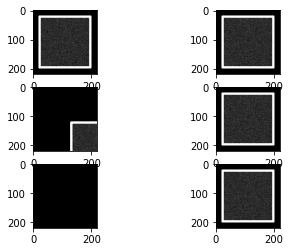

In [12]:
import os, sys
sys.path.append('/home/ltetrel/DeepNeuroAN/deepneuroan/')
sys.path.append('/home/ltetrel/DeepNeuroAN/')
sys.path.append('/home/ltetrel/Documents/work/DeepNeuroAN/deepneuroan/')
sys.path.append('/home/ltetrel/Documents/work/DeepNeuroAN/')

import numpy as np
np.set_printoptions(precision=2)
import tensorflow as tf

from preproc import create_ref_grid
import deepneuroan.utils as utils
import SimpleITK as sitk

tf.keras.backend.clear_session()

def mem_size(var):
    return (tf.size(var).numpy() * sys.getsizeof(var.dtype))/(1024**3)

# inspired from https://tensorlayer.readthedocs.io/en/latest/_modules/tensorlayer/layers/spatial_transformer.html
def _repeat(x, n_repeats):
    rep = tf.transpose(a=tf.expand_dims(tf.ones(
                                                shape=tf.stack([n_repeats,])
                                                ), 1)
                       , perm=[1, 0])
    rep = tf.cast(rep, dtype=tf.int32)
    x = tf.matmul(tf.reshape(x, (-1, 1)), rep)
    return tf.reshape(x, [-1])

def _prev_interpolate(im, p, out_size, min_ref_grid, max_ref_grid):

    # getting position coords as arrays
    x = tf.reshape(tf.slice(p, [0, 0, 0], [-1, 1, -1]), [-1])
    y = tf.reshape(tf.slice(p, [0, 1, 0], [-1, 1, -1]), [-1])
    z = tf.reshape(tf.slice(p, [0, 2, 0], [-1, 1, -1]), [-1])

    # constants
    num_batch = tf.shape(im)[0]
    height = tf.shape(im)[1]
    width = tf.shape(im)[2]
    depth = tf.shape(im)[3]
    channels = tf.shape(im)[4]
    out_height = out_size[0]
    out_width = out_size[1]
    out_depth = out_size[2]
    height_f = tf.cast(height, dtype=tf.float32)
    width_f = tf.cast(width, dtype=tf.float32)
    depth_f = tf.cast(depth, dtype=tf.float32)
    zero = tf.zeros([], dtype=tf.float32)

    # scale positions to [0, width/height - 1]
    ix = (x - min_ref_grid[0]) * (width_f - 1.)/(max_ref_grid[0] - min_ref_grid[0])
    iy = (y - min_ref_grid[1]) * (height_f - 1.)/(max_ref_grid[1] - min_ref_grid[1])
    iz = (z - min_ref_grid[2]) * (depth_f - 1.)/(max_ref_grid[2] - min_ref_grid[2])

    # border padding mode, for positions outside of refrence grid
    ix = tf.clip_by_value(ix, zero, width_f - 1)
    iy = tf.clip_by_value(iy, zero, height_f - 1)
    iz = tf.clip_by_value(iz, zero, depth_f - 1)

    # get corner indexes based on the scaled positions
    # nwt stands for north-west-top; seb stands for south-east-bottom
    ix_nwt = tf.floor(ix)
    iy_nwt = tf.floor(iy)
    iz_nwt = tf.floor(iz)
    ix_net = ix_nwt + 1
    iy_net = iy_nwt
    iz_net = iz_nwt
    ix_swt = ix_nwt
    iy_swt = iy_nwt + 1
    iz_swt = iz_nwt
    ix_set = ix_nwt + 1
    iy_set = iy_nwt + 1
    iz_set = iz_nwt
    ix_nwb = ix_nwt
    iy_nwb = iy_nwt
    iz_nwb = iz_nwt + 1
    ix_neb = ix_nwt + 1
    iy_neb = iy_nwt
    iz_neb = iz_nwt + 1
    ix_swb = ix_nwt
    iy_swb = iy_nwt + 1
    iz_swb = iz_nwt + 1
    ix_seb = ix_nwt + 1
    iy_seb = iy_nwt + 1
    iz_seb = iz_nwt + 1

    # calculate the weights for each p position
    nwt = tf.expand_dims(((ix_seb - ix)    * (iy_seb - iy)    * (iz_seb - iz)), 1)
    net = tf.expand_dims(((ix    - ix_swb) * (iy_swb - iy)    * (iz_swb - iz)), 1)
    swt = tf.expand_dims(((ix_neb - ix)    * (iy    - iy_neb) * (iz_neb - iz)), 1)
    set = tf.expand_dims(((ix    - ix_nwb) * (iy    - iy_nwb) * (iz_nwb - iz)), 1)
    nwb = tf.expand_dims(((ix_set - ix)    * (iy_set - iy)    * (iz - iz_set)), 1)
    neb = tf.expand_dims(((ix    - ix_swt) * (iy_swt - iy)    * (iz - iz_swt)), 1)
    swb = tf.expand_dims(((ix_net - ix)    * (iy    - iy_net) * (iz - iz_net)), 1)
    seb = tf.expand_dims(((ix    - ix_nwt) * (iy    - iy_nwt) * (iz - iz_nwt)), 1)

    # gather input img values from positions
    # get corners idx
    ibatch = _repeat(tf.range(num_batch) * height * width * depth, out_height * out_width * out_depth)
    idx_nwt = ibatch + tf.cast(tf.clip_by_value(ix_nwt, zero, width_f - 1), tf.int32) + tf.cast(tf.clip_by_value(iy_nwt, zero, height_f - 1), tf.int32) * width + tf.cast(tf.clip_by_value(iz_nwt, zero, depth_f - 1), tf.int32) * width * height
    idx_net = ibatch + tf.cast(tf.clip_by_value(ix_net, zero, width_f - 1), tf.int32) + tf.cast(tf.clip_by_value(iy_net, zero, height_f - 1), tf.int32) * width + tf.cast(tf.clip_by_value(iz_net, zero, depth_f - 1), tf.int32) * width * height
    idx_swt = ibatch + tf.cast(tf.clip_by_value(ix_swt, zero, width_f - 1), tf.int32) + tf.cast(tf.clip_by_value(iy_swt, zero, height_f - 1), tf.int32) * width + tf.cast(tf.clip_by_value(iz_swt, zero, depth_f - 1), tf.int32) * width * height
    idx_set = ibatch + tf.cast(tf.clip_by_value(ix_set, zero, width_f - 1), tf.int32) + tf.cast(tf.clip_by_value(iy_set, zero, height_f - 1), tf.int32) * width + tf.cast(tf.clip_by_value(iz_set, zero, depth_f - 1), tf.int32) * width * height
    idx_nwb = ibatch + tf.cast(tf.clip_by_value(ix_nwb, zero, width_f - 1), tf.int32) + tf.cast(tf.clip_by_value(iy_nwb, zero, height_f - 1), tf.int32) * width + tf.cast(tf.clip_by_value(iz_nwb, zero, depth_f - 1), tf.int32) * width * height
    idx_neb = ibatch + tf.cast(tf.clip_by_value(ix_neb, zero, width_f - 1), tf.int32) + tf.cast(tf.clip_by_value(iy_neb, zero, height_f - 1), tf.int32) * width + tf.cast(tf.clip_by_value(iz_neb, zero, depth_f - 1), tf.int32) * width * height
    idx_swb = ibatch + tf.cast(tf.clip_by_value(ix_swb, zero, width_f - 1), tf.int32) + tf.cast(tf.clip_by_value(iy_swb, zero, height_f - 1), tf.int32) * width + tf.cast(tf.clip_by_value(iz_swb, zero, depth_f - 1), tf.int32) * width * height
    idx_seb = ibatch + tf.cast(tf.clip_by_value(ix_seb, zero, width_f - 1), tf.int32) + tf.cast(tf.clip_by_value(iy_seb, zero, height_f - 1), tf.int32) * width + tf.cast(tf.clip_by_value(iz_seb, zero, depth_f - 1), tf.int32) * width * height
 
    # gather input image values from idx
    im_flat = tf.reshape(im, tf.stack([-1, channels]))
    I_nwt = tf.gather(im_flat, idx_nwt)
    I_net = tf.gather(im_flat, idx_net)
    I_swt = tf.gather(im_flat, idx_swt)
    I_set = tf.gather(im_flat, idx_set)
    I_nwb = tf.gather(im_flat, idx_nwb)
    I_neb = tf.gather(im_flat, idx_neb)
    I_swb = tf.gather(im_flat, idx_swb)
    I_seb = tf.gather(im_flat, idx_seb)
    
    output = tf.add_n([nwt * I_nwt, net * I_net, swt * I_swt, set * I_set, nwb * I_nwb, neb * I_neb, swb * I_swb, seb * I_seb])
    return output

def _interpolate(im, p, out_size, min_ref_grid, max_ref_grid, method="nn"):

    # constants
    num_batch = tf.shape(im)[0]
    height = tf.shape(im)[1]
    width = tf.shape(im)[2]
    depth = tf.shape(im)[3]
    channels = tf.shape(im)[4]
    out_height = out_size[0]
    out_width = out_size[1]
    out_depth = out_size[2]
    height_f = tf.cast(height, dtype=tf.float32)
    width_f = tf.cast(width, dtype=tf.float32)
    depth_f = tf.cast(depth, dtype=tf.float32)
    zero = tf.zeros([], dtype=tf.float32)
    im_flat = tf.reshape(im, tf.stack([-1, channels]))

    # scale positions to [0, width/height - 1]
    ix = (tf.reshape(p[:, 0, :], [-1]) - min_ref_grid[0]) * (width_f - 1.)/(max_ref_grid[0] - min_ref_grid[0])
    iy = (tf.reshape(p[:, 1, :], [-1]) - min_ref_grid[1]) * (height_f - 1.)/(max_ref_grid[1] - min_ref_grid[1])
    iz = (tf.reshape(p[:, 2, :], [-1]) - min_ref_grid[2]) * (depth_f - 1.)/(max_ref_grid[2] - min_ref_grid[2])

    # border padding mode, for positions outside of refrence grid
    ix = tf.clip_by_value(ix, zero, width_f - 1)
    iy = tf.clip_by_value(iy, zero, height_f - 1)
    iz = tf.clip_by_value(iz, zero, depth_f - 1)

    # if we use bilinear interpolation, we calculate each area between corners and positions to get the weights for each input pixel
    if method == "bilinear":
        # get corner indexes based on the scaled positions
        # nwt corner stands for north-west-top; seb stands for south-east-bottom
        ix_nwt = tf.floor(ix)
        iy_nwt = tf.floor(iy)
        iz_nwt = tf.floor(iz)
        ix_net = ix_nwt + 1.
        iy_net = iy_nwt
        iz_net = iz_nwt
        ix_swt = ix_nwt
        iy_swt = iy_nwt + 1.
        iz_swt = iz_nwt
        ix_set = ix_nwt + 1.
        iy_set = iy_nwt + 1.
        iz_set = iz_nwt
        ix_nwb = ix_nwt
        iy_nwb = iy_nwt
        iz_nwb = iz_nwt + 1.
        ix_neb = ix_nwt + 1.
        iy_neb = iy_nwt
        iz_neb = iz_nwt + 1.
        ix_swb = ix_nwt
        iy_swb = iy_nwt + 1.
        iz_swb = iz_nwt + 1.
        ix_seb = ix_nwt + 1.
        iy_seb = iy_nwt + 1.
        iz_seb = iz_nwt + 1.

        # calculate the weights for each p position
        nwt = tf.expand_dims(((ix_seb - ix)    * (iy_seb - iy)    * (iz_seb - iz)), 1)
        net = tf.expand_dims(((ix    - ix_swb) * (iy_swb - iy)    * (iz_swb - iz)), 1)
        swt = tf.expand_dims(((ix_neb - ix)    * (iy    - iy_neb) * (iz_neb - iz)), 1)
        set = tf.expand_dims(((ix    - ix_nwb) * (iy    - iy_nwb) * (iz_nwb - iz)), 1)
        nwb = tf.expand_dims(((ix_set - ix)    * (iy_set - iy)    * (iz - iz_set)), 1)
        neb = tf.expand_dims(((ix    - ix_swt) * (iy_swt - iy)    * (iz - iz_swt)), 1)
        swb = tf.expand_dims(((ix_net - ix)    * (iy    - iy_net) * (iz - iz_net)), 1)
        seb = tf.expand_dims(((ix    - ix_nwt) * (iy    - iy_nwt) * (iz - iz_nwt)), 1)

        # gather input pixel values from corners idx
        ibatch = _repeat(tf.range(num_batch) * height * width * depth, out_height * out_width * out_depth)
        idx_nwt = ibatch + tf.cast(tf.math.minimum(width_f - 1, ix_nwt), tf.int32) + tf.cast(tf.math.minimum(height_f - 1, iy_nwt), tf.int32) * width + tf.cast(tf.math.minimum(depth_f - 1, iz_nwt), tf.int32) * width * height
        idx_net = ibatch + tf.cast(tf.math.minimum(width_f - 1, ix_net), tf.int32) + tf.cast(tf.math.minimum(height_f - 1, iy_net), tf.int32) * width + tf.cast(tf.math.minimum(depth_f - 1, iz_net), tf.int32) * width * height
        idx_swt = ibatch + tf.cast(tf.math.minimum(width_f - 1, ix_swt), tf.int32) + tf.cast(tf.math.minimum(height_f - 1, iy_swt), tf.int32) * width + tf.cast(tf.math.minimum(depth_f - 1, iz_swt), tf.int32) * width * height
        idx_set = ibatch + tf.cast(tf.math.minimum(width_f - 1, ix_set), tf.int32) + tf.cast(tf.math.minimum(height_f - 1, iy_set), tf.int32) * width + tf.cast(tf.math.minimum(depth_f - 1, iz_set), tf.int32) * width * height
        idx_nwb = ibatch + tf.cast(tf.math.minimum(width_f - 1, ix_nwb), tf.int32) + tf.cast(tf.math.minimum(height_f - 1, iy_nwb), tf.int32) * width + tf.cast(tf.math.minimum(depth_f - 1, iz_nwb), tf.int32) * width * height
        idx_neb = ibatch + tf.cast(tf.math.minimum(width_f - 1, ix_neb), tf.int32) + tf.cast(tf.math.minimum(height_f - 1, iy_neb), tf.int32) * width + tf.cast(tf.math.minimum(depth_f - 1, iz_neb), tf.int32) * width * height
        idx_swb = ibatch + tf.cast(tf.math.minimum(width_f - 1, ix_swb), tf.int32) + tf.cast(tf.math.minimum(height_f - 1, iy_swb), tf.int32) * width + tf.cast(tf.math.minimum(depth_f - 1, iz_swb), tf.int32) * width * height
        idx_seb = ibatch + tf.cast(tf.math.minimum(width_f - 1, ix_seb), tf.int32) + tf.cast(tf.math.minimum(height_f - 1, iy_seb), tf.int32) * width + tf.cast(tf.math.minimum(depth_f - 1, iz_seb), tf.int32) * width * height
        
        
        # gather input image values from idx
        I_nwt = tf.gather(im_flat, idx_nwt)
        I_net = tf.gather(im_flat, idx_net)
        I_swt = tf.gather(im_flat, idx_swt)
        I_set = tf.gather(im_flat, idx_set)
        I_nwb = tf.gather(im_flat, idx_nwb)
        I_neb = tf.gather(im_flat, idx_neb)
        I_swb = tf.gather(im_flat, idx_swb)
        I_seb = tf.gather(im_flat, idx_seb)
        
        output = tf.add_n([nwt * I_nwt, net * I_net, swt * I_swt, set * I_set, nwb * I_nwb, neb * I_neb, swb * I_swb, seb * I_seb])
    
    # else if method is nearest neighbor, we get the pixel values from the north-west-top corner
    elif method == "nn":
        # get corner indexes based on the scaled positions
        # nwt corner stands for north-west-top; seb stands for south-east-bottom
        ix_nwt = tf.floor(ix)
        iy_nwt = tf.floor(iy)
        iz_nwt = tf.floor(iz)

        # gather input pixel values from nwt corner idx
        ibatch = _repeat(tf.range(num_batch) * height * width * depth, out_height * out_width * out_depth)
        idx_nwt = ibatch + tf.cast(ix_nwt, tf.int32) + tf.cast(iy_nwt, tf.int32) * width + tf.cast(iz_nwt, tf.int32) * width * height
        output = tf.gather(im_flat, idx_nwt)

    return output

n_batch = 3
transfos = tf.random.uniform(shape=(n_batch, 7), seed=0, dtype=tf.float32) #quaternions (4,) + translations (3,) + scales (3,)
transfos = tf.stack( [0.*tf.ones(shape=(7), dtype=tf.float32), (-10)*tf.ones(shape=(7), dtype=tf.float32), (-30)*tf.ones(shape=(7), dtype=tf.float32)] )
U_single = 34*tf.random.uniform((1, 220, 220, 220, 1), seed=0, dtype=tf.float32)

np.random.seed(0)
U_single = 34*np.random.rand(1, 220, 220, 220, 1)
U_single[:, 20:25, :, :, :] = 255.
U_single[:, :, 20:25, :, :] = 255.
U_single[:, :, :, 20:25, :] = 255.
U_single[:, 195:200, :, :, :] = 255.
U_single[:, :, 195:200, :, :] = 255.
U_single[:, :, :, 195:200, :] = 255.
U_single[:, :20, :, :, :] = 0.
U_single[:, :, :20, :, :] = 0.
U_single[:, :20, :, :, :] = 0.
U_single[:, 200:, :, :, :] = 0.
U_single[:, :, 200:, :, :] = 0.
U_single[:, :, :, 200:, :] = 0.

U = tf.tile( tf.cast(U_single, dtype=tf.float32), (n_batch, 1, 1, 1, 1), name=None)
out_size = [220, 220, 220]


# U_single = 34*tf.random.uniform((1, 15, 15, 15, 1), seed=0, dtype=tf.float32)

# np.random.seed(seed=0)
# U_single = 34*np.random.rand(1, 15, 15, 15, 1)
# U_single[:, 1:2, :, :, :] = 255.
# U_single[:, :, 1:2, :, :] = 255.
# U_single[:, :, :, 1:2, :] = 255.
# U_single[:, 13:14, :, :, :] = 255.
# U_single[:, :, 13:14, :, :] = 255.
# U_single[:, :, :, 13:14, :] = 255.
# U_single[:, :1, :, :, :] = 0.
# U_single[:, :, :1, :, :] = 0.
# # U_single[:, :, :, :4, :] = 0.
# U_single[:, 14:, :, :, :] = 0.
# U_single[:, :, 14:, :, :] = 0.
# # U_single[:, :, :, 36:, :] = 0.

# U = tf.tile( tf.cast(U_single, dtype=tf.float32), (n_batch, 1, 1, 1, 1), name=None)
# out_size = [15, 15, 15]

name='BatchSpatialTransformer3dAffine'

ref_size = tf.shape(U)[1:-1]
# TODO: min[d] and max[d] correspond to cartesian coordinate d (d=0 is x, d=1 is y ..)
min_ref_grid = tf.constant([-30., -10., 15.])
max_ref_grid = tf.constant([-18., 10., 37])
# min_ref_grid = tf.constant([0., 0., 0.], dtype=tf.float32)
# max_ref_grid = tf.constant(tf.stack(tf.cast(ref_size, dtype=tf.float32) - 1), dtype=tf.float32)

import time
tic = time.time()

with tf.compat.v1.variable_scope(name):
    input_dim = U
    
    num_batch = tf.shape(input=input_dim)[0]
    num_channels = tf.shape(input=input_dim)[-1]
    
    #if the transformations has length > 7, then we apply scaling
    if tf.shape(transfos)[-1] > 7:
        thetas = tf.linalg.diag(transfos[:, -3:])
    else:
        thetas = tf.eye(num_rows=3, batch_shape=[num_batch])
        
    #if the transformations has length > 4, then we apply translation
    if tf.shape(transfos)[-1] > 4:  
        thetas = tf.concat(axis=2, values=[thetas, transfos[:, 4:7, tf.newaxis]])
    else:
        thetas = tf.concat(axis=2, values=[thetas, tf.zeros((num_batch, 3, 1))])
    
    # physical points of source volume, from template affine
    # if we don't have volume affine, we use a grid [-1, 1]
    if (min_ref_grid is None) | (max_ref_grid is None):
        min_ref_grid = (-1)*tf.ones(3)
        max_ref_grid = tf.ones(3)
    m_y, m_z, m_x = tf.meshgrid(tf.linspace(min_ref_grid[1], max_ref_grid[1], ref_size[0]),
                                tf.linspace(min_ref_grid[2], max_ref_grid[2], ref_size[2]),
                                tf.linspace(min_ref_grid[0], max_ref_grid[0], ref_size[1]),
                                indexing='xy')
    
    # physical points for quaternion
    grid = tf.concat(axis=0, values=[tf.reshape(m_x, (1, -1)), tf.reshape(m_y, (1, -1)), tf.reshape(m_z, (1, -1))])
    grid = tf.transpose(grid)
    print("quaternion rotate here")
#     grid = tfg.geometry.transformation.quaternion.rotate(grid, transfos[:, :4])

    grid = tf.transpose(grid)
    grid = tf.concat(axis=0, values=[grid, tf.ones_like(tf.reshape(m_x, (1, -1)))])
    # adding batch dimension
    grid = tf.expand_dims(grid, 0)
    grid = tf.reshape(grid, [-1])
    grid = tf.tile(grid, tf.stack([num_batch]))
    # final reshape for transformation
    grid = tf.reshape(grid, tf.stack([num_batch, 4, -1]))
    
    T_g = tf.matmul(thetas, grid)

    tic = time.time()
    for i in range(10):
        input_transformed = _interpolate(U, T_g, out_size, min_ref_grid, max_ref_grid)
    ElpsTime = time.time() - tic
    print("*** Total current nn %1.3f s ***"%(ElpsTime))

    tic = time.time()
    for i in range(10):
        input_transformed = _prev_interpolate(U, T_g, out_size, min_ref_grid, max_ref_grid)
    ElpsTime = time.time() - tic
    print("*** Total previous %1.3f s ***"%(ElpsTime))

    tic = time.time()
    for i in range(10):
        input_transformed = _interpolate(U, T_g, out_size, min_ref_grid, max_ref_grid, method="bilinear")
    ElpsTime = time.time() - tic
    print("*** Total current bilinear %1.3f s ***"%(ElpsTime))

    output = tf.reshape(input_transformed, tf.stack([num_batch, *out_size, num_channels]))

ElpsTime = time.time() - tic
print("*** Total %1.3f s ***"%(ElpsTime))

# from vprof import runner
# runner.run(my_func, 'cmhp', host='localhost', port=8000)

import matplotlib.pyplot as plt

plt.subplot(321)
batch = 0
plt.imshow(output[batch,:,:,0,0], cmap="gray", vmin=0, vmax=100)
plt.subplot(322)
plt.imshow(U[batch,:,:,0,0], cmap="gray", vmin=0, vmax=100)

plt.subplot(323)
batch = 1
plt.imshow(output[batch,:,:,0,0], cmap="gray", vmin=0, vmax=100)
plt.subplot(324)
plt.imshow(U[batch,:,:,0,0], cmap="gray", vmin=0, vmax=100)

plt.subplot(325)
batch = 2
plt.imshow(output[batch,:,:,0,0], cmap="gray", vmin=0, vmax=100)
plt.subplot(326)
plt.imshow(U[batch,:,:,0,0], cmap="gray", vmin=0, vmax=100)
plt.show()

In [11]:
# trying with a simple transform
t_np = np.array([[1, 0, 0, 0]
                 ,[0, 1, 0, -10]
                 ,[0, 0, 1, -30]
                 ,[0, 0, 0, 1]])

affine = sitk.Euler3DTransform()
affine.SetTranslation((-10, 30, 0))

data_dir = "./data"
filepath = data_dir + "/ses-vid001_task-video_run-01_bold_vol-0001_transfo-%06d.nii.gz" %(1)
ref_grid = create_ref_grid()
source_brain = sitk.ReadImage(filepath, sitk.sitkFloat32)

import time
tic = time.time()
for i in range(30):
    brain_to_grid = sitk.Resample(source_brain, ref_grid, affine, sitk.sitkLinear, 0.0, sitk.sitkFloat32)
ElpsTime = time.time() - tic
print("*** Total %1.3f s ***"%(ElpsTime))

*** Total 0.987 s ***
